## DCGAN Deep Convolutional Generative Adversarial Network

DCGAN與GAN的差別在於  
DCGAN在網路中加入了Convolution layer  
將GAN的概念擴展到卷機網路  
對於用來生成圖像概念的結果有著幫助  

## DataSet

利用動漫圖像來做訓練資料集  
圖像的原始大小為128*128  
reference :　[李宏毅](https://www.youtube.com/watch?v=DQNNMiAP5lw&list=PLJV_el3uVTsMq6JEFPW35BCiOQTsoqwNw)

length of train data 33415


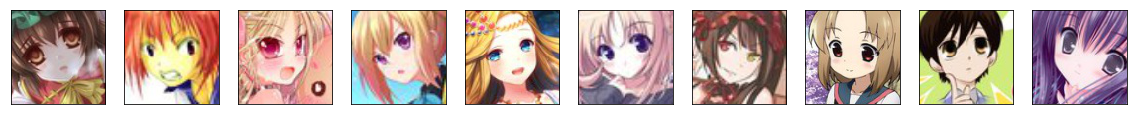

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

Image_path = './AnimeDataset/faces'
print('length of train data %d' %(len(os.listdir(Image_path))))

plt.figure(figsize=(20,2))
for i,frame in zip(range(0,10),['{}.jpg'.format(i) for i in range(0,10)]):
    img_path = os.path.join(Image_path,frame)
    img = plt.imread(img_path)
    plt.subplot(1,10,i+1),plt.imshow(img)
    plt.xticks([]),plt.yticks([])

## DataGenerator  
利用keras的ImageDataGenerator來把圖案批次產出  
做了圖像預處理成64*64大小

In [2]:
from keras.layers import Input, Dense, Reshape, BatchNormalization, Flatten, Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Data_path = './AnimeDataset'
datagen = ImageDataGenerator()
batch_size =100


Train_gen = datagen.flow_from_directory(
                Data_path,
                target_size=(64,64),
                batch_size=int(batch_size/2),
                class_mode=None)

Using TensorFlow backend.


Found 33415 images belonging to 1 classes.


## Generator
引入leakyrelu 
並且中間層利用upsampling的方式把輸出轉成64*64  
也加入BathNormalization來幫助訓練  
最後的輸出維度為3維利用tanh讓結果投射到[-1,1]之間  



In [3]:
Generator = Sequential()

Generator.add(Dense(128*16*16,input_dim=100,activation=LeakyReLU(alpha=0.2)))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(Reshape((16,16,128)))  
Generator.add(UpSampling2D())
Generator.add(Conv2D(128,4,padding='same',activation=LeakyReLU(alpha=0.2)))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(UpSampling2D())
Generator.add(Conv2D(64,4,padding='same',activation=LeakyReLU(alpha=0.2)))
Generator.add(BatchNormalization(momentum=0.5))
Generator.add(Conv2D(3,3,padding='same',activation='tanh'))

Generator.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 64, 128)       0         
__________

## Optimizer

這裡的learning rate與beta值參考網路的來調整

In [4]:
optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

## Discriminator

Discriminator一開始加入了BN與4層的CNN  
但是在訓練的時候，Discriminator的loss很快地就下降到0  
網路也就壞掉了，generator會變成一隻無頭蒼蠅，怎麼train都無法收斂  
因此拔掉了BN與最後一層的CNN，讓discriminator變弱一些  
GAN也因此可以動了起來

In [5]:
Discriminator = Sequential()

Discriminator.add(Conv2D(32,4,padding='same',activation=LeakyReLU(alpha=0.2),input_shape=(64,64,3)))
#Discriminator.add(BatchNormalization(momentum=0.5))
Discriminator.add(Conv2D(64,4,padding='same',activation=LeakyReLU(alpha=0.2)))
#Discriminator.add(BatchNormalization(momentum=0.5))
Discriminator.add(Conv2D(128,4,padding='same',activation=LeakyReLU(alpha=0.2)))
#Discriminator.add(BatchNormalization(momentum=0.5))
#Discriminator.add(Conv2D(256,4,padding='same',activation=LeakyReLU(alpha=0.2)))
#Discriminator.add(BatchNormalization(momentum=0.5))
Discriminator.add(Flatten())
Discriminator.add(Dense(1, activation='sigmoid'))
     
Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
Discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 524289    
Total params: 689,889
Trainable params: 689,889
Non-trainable params: 0
_________________________________________________________________


## GAN
一樣的把兩個網路組合起來成為GAN網路

In [6]:
Discriminator.trainable = False
GAN = Sequential()
GAN.add(Generator)
GAN.add(Discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Training data generator

定義一個函數作為discriminator訓練資料集的輸出  
資料集的前半為真實訓練及  
後半為Generator生成的假圖  

In [7]:
def train_D_data_gen():
    sample = np.empty((int(batch_size),64,64,3),dtype=np.float32)
    data_etract = Train_gen.next()
    if (data_etract.shape[0] != int(batch_size/2)):
        data_etract = Train_gen.next()
    sample[0:int(batch_size/2)] = (data_etract-127.5)/127.5
    noise = np.random.normal(0,1,(int(batch_size/2),100))
    synthesis_img = Generator.predict(noise)
    sample[int(batch_size/2):batch_size] = synthesis_img
    label = np.concatenate((np.ones(int(batch_size/2)),np.zeros(len(synthesis_img))))
    #label += 0.03 * np.random.random(label.shape)
    return sample, label

## Training

Training phase  
訓練10000 epoches by 100 batches  
每epoch訓練約0.5s 

Instructions for updating:
Use tf.cast instead.


C:\Users\a2720\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator: d_loss: 0.676292], [ Generator: loss: 0.040894], Training time: 8 s
epoch: 1000, [Discriminator: d_loss: 0.538261], [ Generator: loss: 1.071492], Training time: 516 s
epoch: 2000, [Discriminator: d_loss: 0.448910], [ Generator: loss: 1.082595], Training time: 520 s
epoch: 3000, [Discriminator: d_loss: 0.310891], [ Generator: loss: 1.965611], Training time: 520 s
epoch: 4000, [Discriminator: d_loss: 0.323273], [ Generator: loss: 3.197155], Training time: 521 s
epoch: 5000, [Discriminator: d_loss: 0.180830], [ Generator: loss: 1.874465], Training time: 521 s
epoch: 6000, [Discriminator: d_loss: 0.197304], [ Generator: loss: 1.955303], Training time: 523 s
epoch: 7000, [Discriminator: d_loss: 0.128292], [ Generator: loss: 2.766189], Training time: 519 s
epoch: 8000, [Discriminator: d_loss: 0.242304], [ Generator: loss: 2.229490], Training time: 520 s
epoch: 9000, [Discriminator: d_loss: 0.166040], [ Generator: loss: 2.812655], Training time: 522 s
total training 

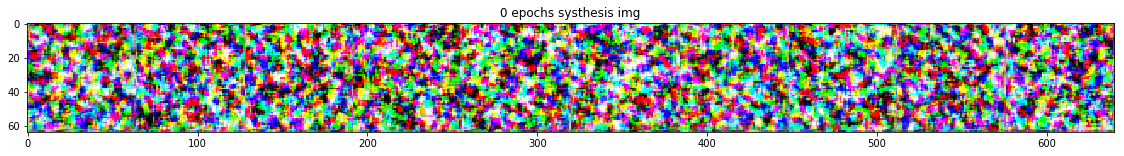

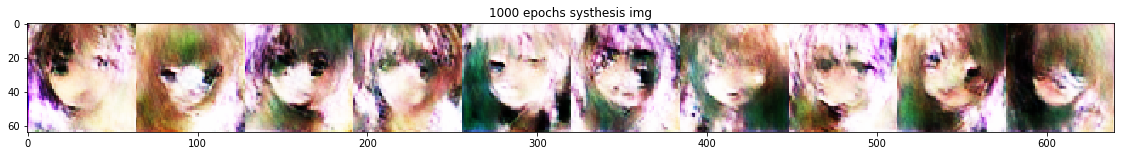

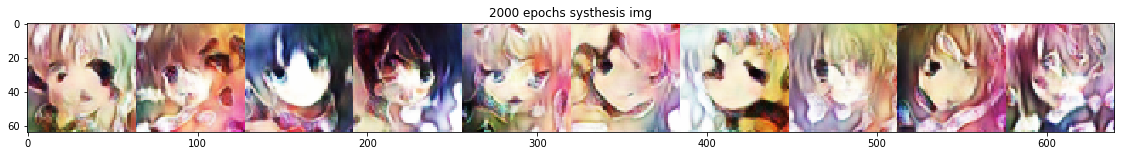

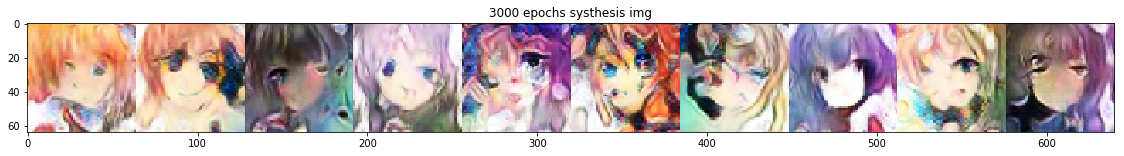

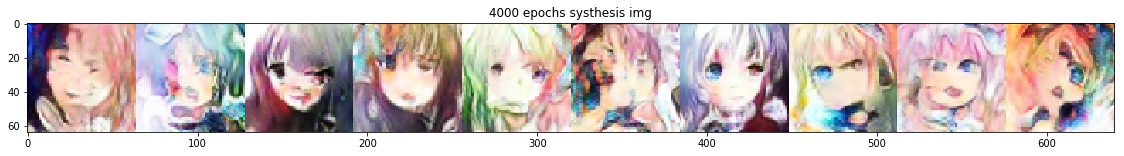

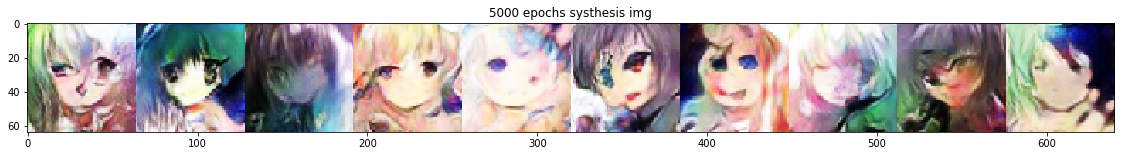

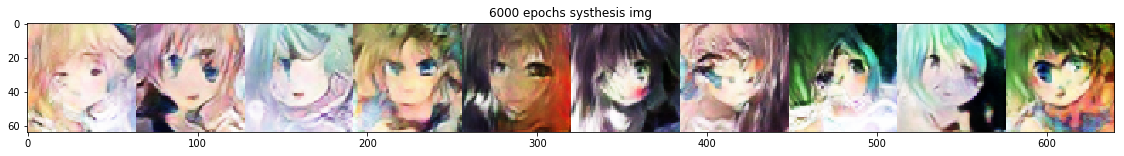

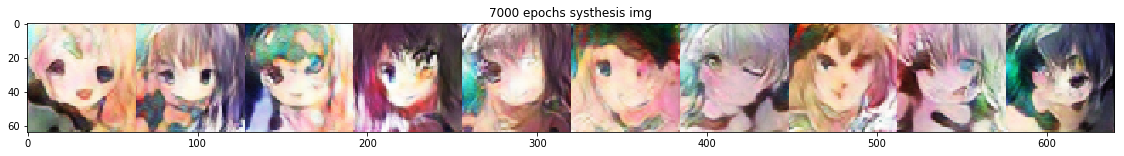

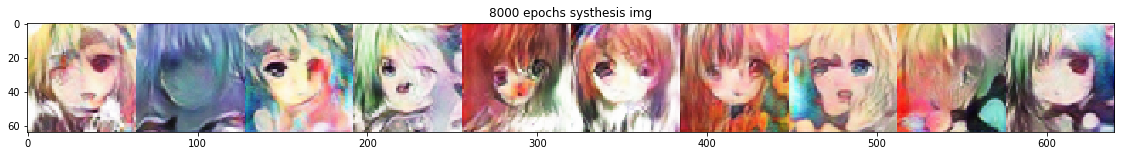

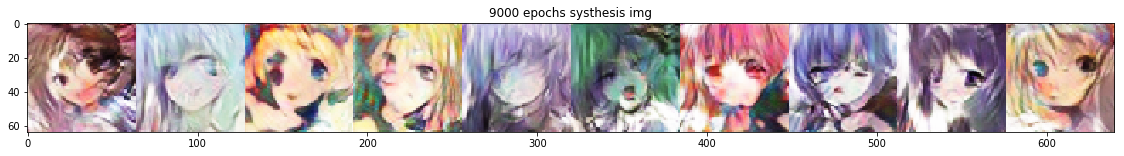

In [9]:
import time
tStart = time.time()
tBegin = tStart
epochs = 10000

for times in range(epochs):
    # train discriminater
    data, label = train_D_data_gen()
    d_loss = Discriminator.train_on_batch(data,label)
    
    #train generator
    noise = np.random.normal(0,1,(batch_size,100))
    noise_target = np.ones(len(noise))
    g_loss = GAN.train_on_batch(noise,noise_target)
    
    #option to see loss
    #print ('epoch: %d, [Discriminator: d_loss: %f], [ Generator: loss: %f]' % (times, d_loss[0], g_loss[0]))
    
    if times%1000 == 0:
        tEnd = time.time()
        print ('epoch: %d, [Discriminator: d_loss: %f], [ Generator: loss: %f], Training time: %d s' 
               % (times, d_loss[0], g_loss[0], tEnd-tStart))
        tStart = tEnd
        img = np.ones((64,640,3))
        noise = np.random.normal(0,1,(10,100))
        synthesis_img = Generator.predict(noise)*127.5+127.5
        #print(synthesis_img[0].min()), print(synthesis_img[0].max()), print(synthesis_img[0].dtype)
        for i in range(10):
            img[:,i*64:(i+1)*64,:]=synthesis_img[i]
        img = img.astype('int32')
        plt.figure(figsize=(20,2)),plt.imshow(img)
        plt.title('%d epochs systhesis img'%times)

tEEnd = time.time()
print('total training time: %d s' %(tEEnd-tBegin) )

## Result

比較一下訓練集跟結果圖  
可以看到生成的結果已經有兩個眼睛與頭髮皮膚這些概念  
但是結果還是滿像異形的  
不過在訓練過程中還是可以看到整體上來說  
有越來越接近我們希望要有的成果  
如果能夠有夠多的訓練，理論上能得到更好的結果

(<Figure size 1440x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x15e6dc42f98>)

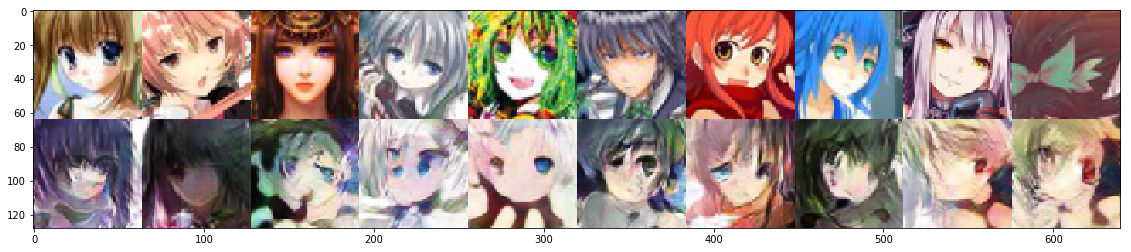

In [11]:
Data, label = train_D_data_gen()
Data = (Data*127.5+127.5).astype('int32')
img = np.ones((128,640,3))
for i in range(10):
    img[0:64,i*64:(i+1)*64,:]=Data[i]
    img[64:128,i*64:(i+1)*64,:]=Data[int(batch_size/2)+i]
img = img.astype('int32')
plt.figure(figsize=(20,4)),plt.imshow(img)

In [15]:
GAN.save_weights('DCGAN_Anime.weight')

## Summray

1. Discriminator不能太強
2. Discriminator輸入圖像歸一化到[-1,1]
3. Generator也是將輸出利用tanh輸出[-1,1]
4. Adam learning rate = 0.0002, Beta=0.5

更多的tips可以在 [Ganhack](https://github.com/soumith/ganhacks) 參考